# Programming Exercise 3.2: Multi-class Classification and Neural Networks (Backpropagation is used)

# 1. Loading Data

In [24]:
import numpy as np
import matplotlib.pyplot as pyplot

In [25]:
import scipy.io as sio
data = sio.loadmat('ex3data1.mat')

In [26]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [34]:
x = data['X'] #input data

In [35]:
X = np.insert(x, 0, 1, axis = 1) #augmented with one input data

In [36]:
Y = data['y'] #output data (labels)

# 2. Visualizing Data 

In [37]:
#For visualization the code for converting these 400 pixels into image is found in Github

In [38]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

In [42]:
#Let us take random choices to show the inputs
m = 5000 #number of samples
rand_choices = np.random.choice(m, size = 100, replace = True)

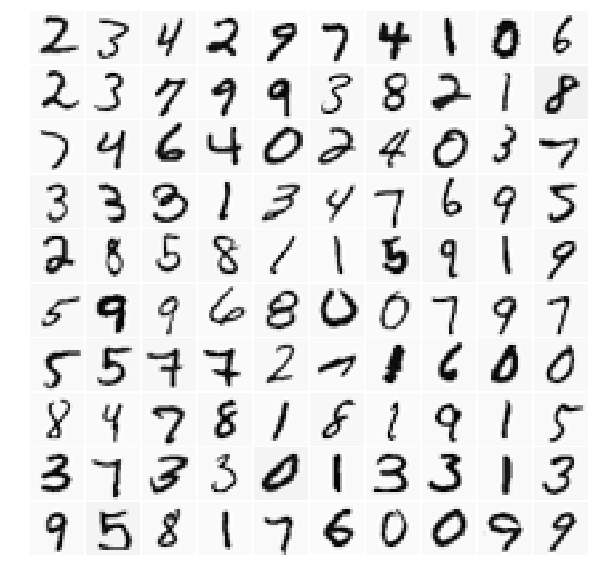

In [43]:
#it is important to give as an argument not-augmented x
displayData(x[rand_choices, :])

# 3. Feedforward

    The architecture of the neural network:
    Shapes:
     - X.shape = (5000, 400)
     - Y.shape = (5000, 1)
     - Theta1.shape = (25, 401)
     - Theta2.shape = (10, 26)
<img src = "neuralnetwork.png">

In [48]:
#importing my in-advance written functions for sigmoid, cost, GDS
import basicFuncs as bf

            It is necessary to initialize weights. To initialize randomly is very important otherwise the activation functions of the same layer won't change in any number of iterations; while neural net wants to have different functions covered by activations (neurons).

In [82]:
#Initializing weights randomly
Theta1 = np.random.random((25, 401))
Theta2 = np.random.random((10, 26))

In [83]:
a0 = X

In [84]:
z1 = a0 @ Theta1.T

In [85]:
a1 = bf.sigmoid(X,Theta1.T)

In [86]:
a1 = np.insert(a1, 0, 1, axis = 1)

In [87]:
z2 = a1 @ Theta2.T

In [88]:
a2 = bf.sigmoid(a1, Theta2.T)

### 3.1 Results with random weights

In [90]:
np.set_printoptions(suppress=True)

In [93]:
a2.shape

(5000, 10)

In [94]:
a2[0]

array([0.99999918, 0.99999886, 0.99996205, 0.99999949, 0.99998957,
       0.99999947, 0.99998746, 0.99999877, 0.99993171, 0.99999159])

        We need to take the index of the highest value in each row of the output a2 and to compare them with Y.

In [102]:
h = []
for i in range(m):
    each_row = a2[i]
    max_value = 0.0
    index_of_max_value = 0
    for j in range(len(each_row)):
        if each_row[j] > max_value:
            max_value = each_row[j]
            index_of_max_value = j
    h.append(index_of_max_value + 1) #we add 1 because indexation in Octave starts with 1
    #in the given dataset in Y index 10 stands for 0

In [104]:
len(h)

5000

            We need to convert h to np array, but since Y.shape is (5000,1), instead of np.array(h), it has been done np.array([h]).

In [119]:
h_matrix = np.array([h])

In [120]:
h_matrix.shape

(1, 5000)

In [121]:
H = h_matrix.T

In [122]:
H.shape

(5000, 1)

In [123]:
Y.shape

(5000, 1)

        Accuracy with random weights is 10%.

In [128]:
np.mean(H == Y) * 100

10.0

# 4. Backpropagation implementation